This notebook collects and processes the complete load profile archive from PG&E.

In [1]:
import sys, os
import datetime as dt
import pandas as pd
import glob
url = "https://www.pge.com/pge_global/forms/mads/profiles"

This retrieves the archive from previous years.

In [2]:
today = dt.datetime.now()
for year in range(1999,today.year):
    file = f"{year}dlp"
    if not os.path.exists("dlp"):
        os.mkdir("dlp")
    if not os.path.exists(f"dlp/{file}.zip"):
        if not os.path.exists(f"dlp/{file}.zip"):
            os.system(f"curl {url}/archive/{file}.zip > dlp/{file}.zip")
            os.system(f"unzip -d dlp dlp/{file}.zip")

This retrieves the data from the current year

In [3]:
# retrieve data for current year
today = dt.datetime.now()
start = dt.datetime(today.year,1,1,0,0,0)
for days in range((today-start).days):
    file = (start+dt.timedelta(days)).strftime("%Y%m%d")
    if not os.path.exists(f"dlp/{file}.dlp"):
        os.system(f"curl {url}/{file}.dlp > dlp/{file}.dlp")
        data = pd.read_csv(f"dlp/{file}.dlp")
        try:
            if str(file) != str(data.columns[0]):
                raise Exception("bad dlp file")
        except:
            os.unlink(f"dlp/{file}.dlp")

This collates all the data collected into a single dataframe named `dlp`.

In [4]:
if os.path.exists("dlp.csv"):
    dlp = pd.read_csv("dlp.csv",index_col=0)
else:
    blocks = []
    for file in sorted(glob.glob("dlp/*.dlp")):
        block = pd.read_csv(file)
        if file != f"dlp/{block.columns[0]}.dlp":
            os.unlink(file)
        else:
            date = dt.datetime.strptime(file,"dlp/%Y%m%d.dlp")
            name = date.strftime('%Y%m%d')
            block = pd.read_csv(f"dlp/{name}.dlp").dropna(how='all').transpose()
            block.columns = block.loc["Profile"]
            block.drop([name,"Profile","Method"],inplace=True)
            block.index = list(map(lambda h: dt.datetime.strptime(name+' '+h,"%Y%m%d %H:%S"),block.index))
            blocks.append(block)
    dlp = pd.concat(blocks,sort=False,copy=False)
    dlp.to_csv("dlp.csv")

This plot displays all the data collected

In [5]:
dlp.plot(figsize=(12,6),grid=True).get_figure().savefig("dlp.png")

The data published by PG&E has changed over the years. The following steps harmonize the data so it can be analysed consistently.

Beginning with trade date 8/1/2016, which will be posted on MADS.PGE.COM on or before 8/8/2016, PG&E will consolidate the current standby DLP profiles (S1S, S1M, S9M, S19, S20) into one standby profile called STBY.  To allow stakeholders to update their systems, in addition to posting the consolidated standby profile STBY, PG&E will continue to post S1S, S1M, S9M, S19, S20 profiles with the same information as profile STBY until further notice.

In [6]:
dlp["STBY"] = dlp.loc[dlp["STBY"].isna().index][["S1S","S1M","S9M","S19","S20"]].sum(axis=1)
print(dlp[["S1S","S1M","S9M","S19","S20","STBY"]].max())

S1S      3194.0174
S1M      5440.9094
S9M      3194.0174
S19      3194.0174
S20     11448.4770
STBY    15970.0870
dtype: float64


PG&E received feedback from stakeholders indicating that the change in name from E1 to RES would affect their current processes.  In order to allow for more time to update these processes, PG&E will post the same profile with two different labels, E1 and RES, until further notice. 

In [7]:
# no changes to dlp

Beginning with trade date June 1, 2016 which will be posted to MADS.PGE.COM on or before June 8, 2016, PG&E will implement the following change:  There will be one residential dynamic load profile instead of two.  Profile RES will replace profiles E1 and E7. 

In [8]:
dlp["RES"] = dlp.loc[dlp["RES"].isna().index][["E1","E7"]].sum(axis=1)
print(dlp[["E1","E7","RES"]].max())

E1     2.0119
E7     3.4330
RES    5.3791
dtype: float64


Although it is not documented, it looks like the RES values are in GW while everything else is in MW. We rescale RES to match COM, IND, and STBY.

In [9]:
dlp["RES"] = dlp.loc[(dlp["RES"]<10.0).index]["RES"]*1000
print(dlp[["E1","E7","RES"]].max())

E1        2.0119
E7        3.4330
RES    5379.1000
dtype: float64


This step consolidates the commercial and industrial load profiles

In [10]:
dlp["COM"] = dlp[["A1","A6","A10","E19V","E19S","E19P"]].sum(axis=1)
print(dlp[["A1","A6","A10","E19V","E19S","E19P","COM"]].max())

A1         5.6402
A6        20.8347
A10       73.0120
E19V     126.0205
E19S     569.4577
E19P     621.1180
COM     1364.6506
dtype: float64


In [11]:
dlp["IND"] = dlp[["E20S","E20P","E20T"]].sum(axis=1)
print(dlp[["E20S","E20P","E20T","IND"]].max())

E20S    1359.1100
E20P    1830.7554
E20T    5581.3600
IND     8372.4900
dtype: float64


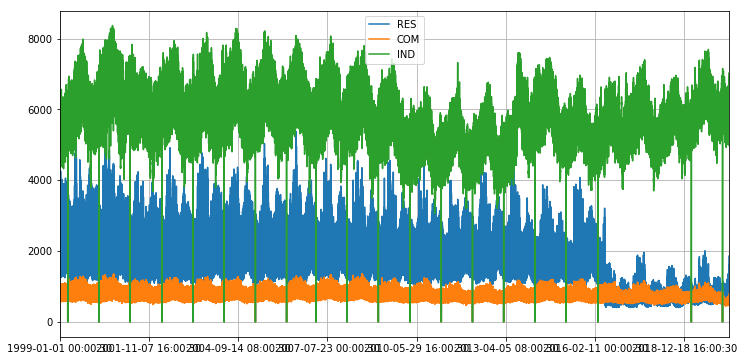

In [12]:
dlp[["RES","COM","IND"]].plot(figsize=(12,6),grid=True).get_figure().savefig("dlp.png")